In [115]:
library(tidyverse)
library(limma)
library(data.table)
library(glue)
library(gridExtra)
library(patchwork)

In [116]:

source("../../../../evaluation_utils/plots/DE_plots.R")
source("../../../../evaluation_utils/plots/eda_plots.R")
source("../../../../evaluation_utils/filtering/filtering_normalization.R")

# Load data - Genes from PG

In [117]:
title = "Genes from PG.txt"

In [118]:
path_to_data <- "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/01_PG_Genes/"
centers <- c("Center1", "Center2", "Center3")

############## Read intensities from all centers ##############
intensities <- lapply(centers, function(center) {
  read_tsv(file.path(path_to_data, paste0(center, "/genes_intensities.tsv")), show_col_types = FALSE)
})

# print number of rows in each data frame
print(paste("Number of rows in each data frame: ", sapply(intensities, nrow)))

# merge intensities using Gene.names column
intensities <- Reduce(function(x, y) {
  merge(x, y, by = "Gene.names")
}, intensities)
intensities <- intensities %>% mutate_all(~replace(., . == 0, NA)) %>%
  column_to_rownames("Gene.names")

print(paste("Number of rows in merged data frame: ", nrow(intensities)))

############## Read metadata from all centers ##############
metadata <- lapply(centers, function(center) {
  read_tsv(file.path(path_to_data, paste0(center, "/metadata.tsv")), 
    col_types = cols(.default = "c"), skip = 1,
    col_names = c("Raw.name", "Quantitative.column.name", "Pool", "Reporter.ion", "Patient", "Group", "Center"))
})
print(paste("Number of rows in each metadata data frame: ", sapply(metadata, nrow)))

# cbind metadata
metadata <- rbindlist(metadata)
print(paste("Number of rows in merged metadata data frame: ", nrow(metadata)))


############## Order column in intensities ##############
intensities <- intensities[,metadata$Quantitative.column.name]

[1] "Number of rows in each data frame:  473"
[2] "Number of rows in each data frame:  504"
[3] "Number of rows in each data frame:  432"
[1] "Number of rows in merged data frame:  356"
[1] "Number of rows in each metadata data frame:  22"
[2] "Number of rows in each metadata data frame:  21"
[3] "Number of rows in each metadata data frame:  22"
[1] "Number of rows in merged metadata data frame:  65"


In [119]:
head(metadata, 2)
head(intensities, 2)

Raw.name,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1


,P_1.RIC_1,P_1.RIC_2,P_1.RIC_3,P_1.RIC_4,P_1.RIC_5,P_1.RIC_6,P_1.RIC_7,P_1.RIC_8,P_1.RIC_9,P_1.RIC_10,⋯,P_6.RIC_2,P_6.RIC_3,P_6.RIC_4,P_6.RIC_5,P_6.RIC_6,P_6.RIC_7,P_6.RIC_8,P_6.RIC_9,P_6.RIC_10,P_6.RIC_11
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,821950,734770,837540,772860,603760,684800,750210,775530,676300,781010,⋯,16985000,15344000,17568000,15650000,16915000,14671000,16319000,16130000,18150000,15035000
A2M,2475200,2514400,2741200,1634700,3682000,1630300,1534500,1744800,2449700,2225900,⋯,15496000,15313000,26161000,13454000,13967000,42095000,12930000,54405000,22753000,16212000


# EDA

In [120]:

# filter full NA rows
intensities <- filter_na_proteins(intensities, metadata, "Quantitative.column.name")


# filter by center - keep only rows with at least 2 non-NA values per center
centers <- c("Center1", "Center2", "Center3")
intensities <- filter_per_center(intensities, metadata, "Quantitative.column.name", centers, "Center")

# filter by condition - keep only rows with at least 2 non-NA values per condition
conditions <- c("heathy", "FSGS") 
intensities <- filter_by_condition(intensities, metadata, "Quantitative.column.name", conditions, "Group")


Filtering out features that have NAs in all columns
	Before filtering: 356 65 
	After filtering: 356 65 
Filtering by center - two not-NA per center
	Before filtering: 356 65 
	After filtering: 352 65 
Filtering by condition - two not-NA per condition
	Before filtering: 352 65 
	After filtering: 352 65 


In [121]:
# # filter rows in intensities if any reference sample column contsin NA
# refs <- metadata[metadata$Group == "Common Reference",]$"Quantitative.column.name"
# print(length(refs))

# cat('Before filtering:', dim(intensities), '\n')
# intensities <- intensities[!rowSums(is.na(intensities[,refs])) > 0,]
# cat('After filtering:', dim(intensities))

In [124]:
samples_center1 <- metadata[metadata$Center == "Center1",]$Quantitative.column.name
samples_center2 <- metadata[metadata$Center == "Center2",]$Quantitative.column.name
samples_center3 <- metadata[metadata$Center == "Center3",]$Quantitative.column.name

In [125]:
plot_density <- plotIntensityDensityByPool(log2(intensities+1), metadata, "Quantitative.column.name", "Pool", paste0("Raw data, ", title))
# plot_pca <- pca_plot(log2(intensities+1), metadata, paste0("Raw data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Raw data, ", title), "")
plot_density_c <- plotIntensityDensityByPool(log2(intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Raw data, ", title)) 


## pca for each center separately
pca_center1 <- pca_plot(log2(intensities[, samples_center1]+1), metadata[metadata$Center == "Center1",], paste0("Raw, Center1, ", title), shape_col = "Pool", show_legend = FALSE)
pca_center2 <- pca_plot(log2(intensities[, samples_center2]+1), metadata[metadata$Center == "Center2",], paste0("Raw, Center2, ", title), shape_col = "Pool", show_legend = FALSE)
pca_center3 <- pca_plot(log2(intensities[, samples_center3]+1), metadata[metadata$Center == "Center3",], paste0("Raw, Center3, ", title), shape_col = "Pool")


layout <- (plot_density + plot_density_c) /
          (plot_boxplot) /
          (pca_center1 + pca_center2 + pca_center3)
layout <- layout + plot_layout(heights = c(4, 3, 4))
options(repr.plot.width=12, repr.plot.height=12)
print(layout)

No id variables; using all as measure variables



No id variables; using all as measure variables

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_summary()`).”


# Test normalizations

## Median

In [14]:
medianNorm_intensities <- medianNorm(intensities) %>% as.data.frame()
rownames(medianNorm_intensities) <- rownames(intensities)

No id variables; using all as measure variables



No id variables; using all as measure variables

Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_summary()`).”


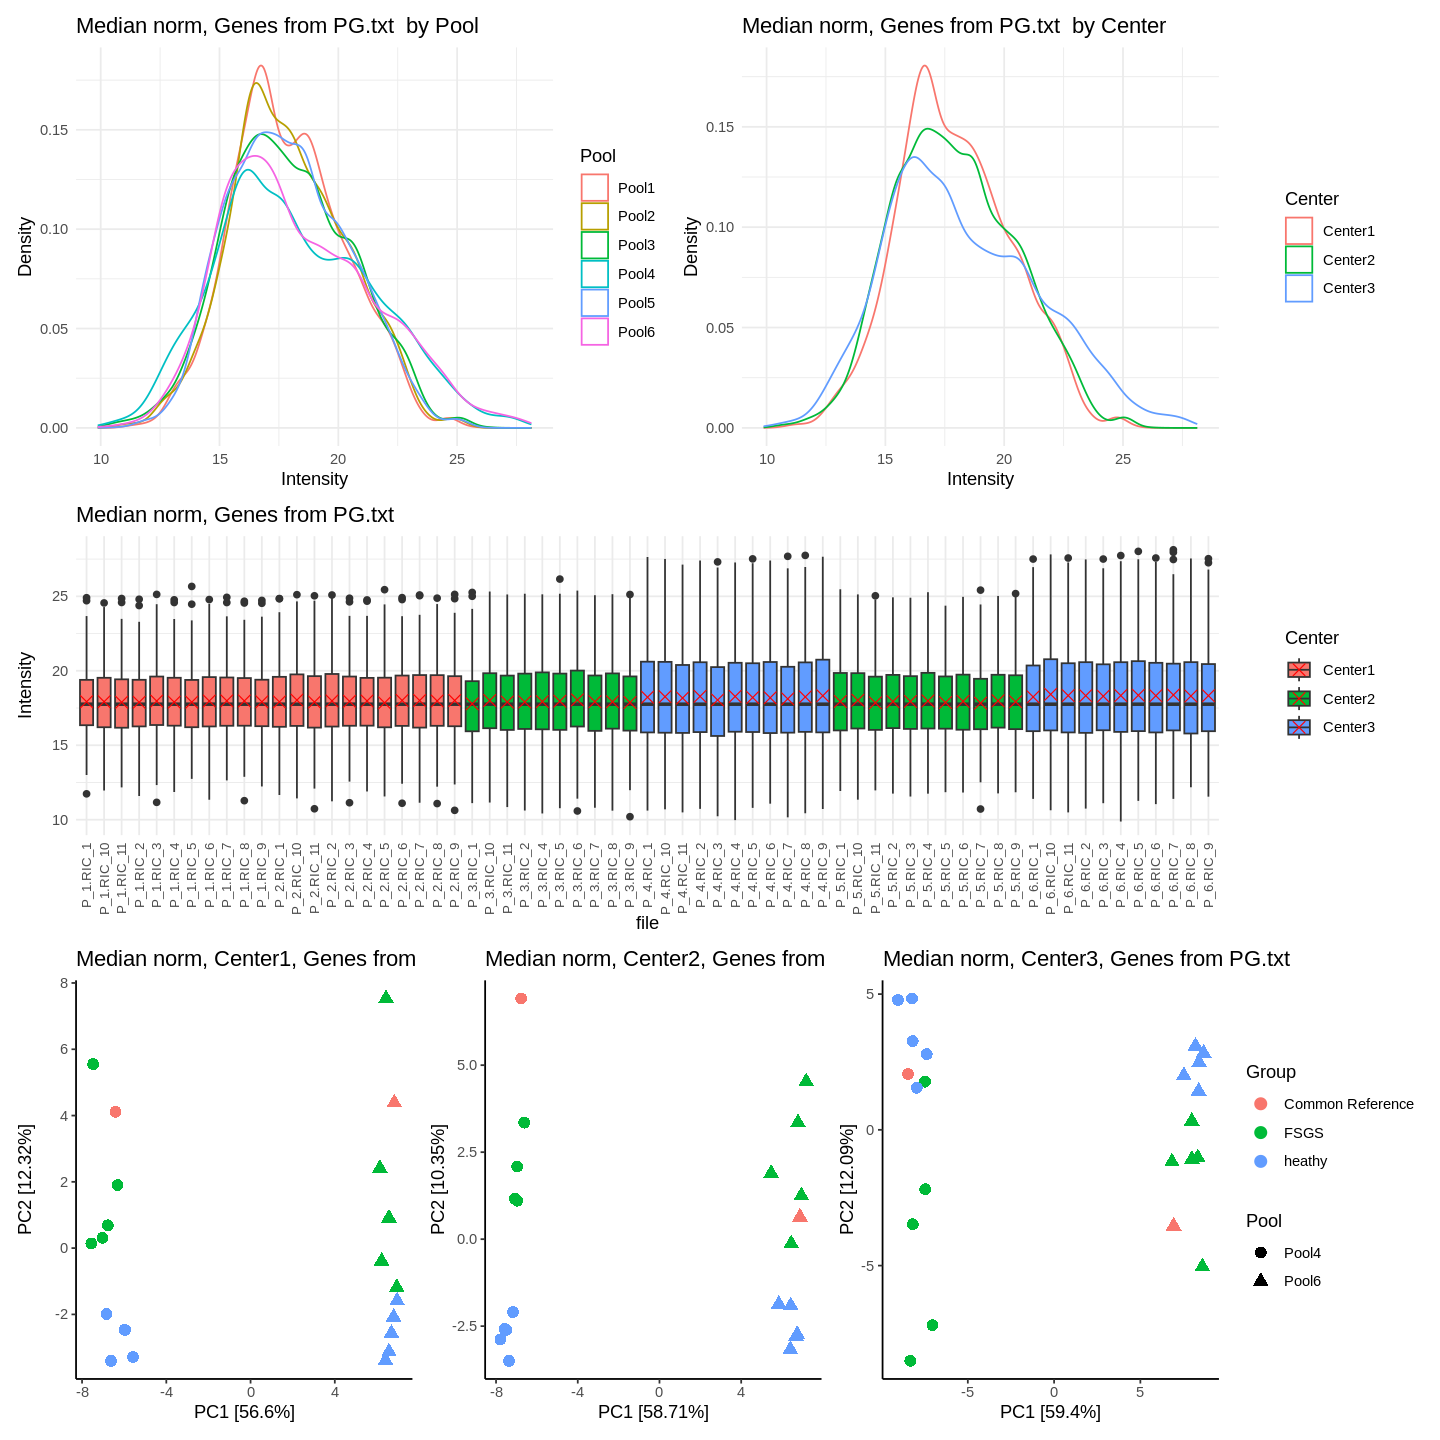

In [15]:
plot_density <- plotIntensityDensityByPool(log2(medianNorm_intensities+1), metadata, "Quantitative.column.name", "Pool", paste0("Median norm, ", title))
plot_pca <- pca_plot(log2(medianNorm_intensities+1), metadata, paste0("Median norm, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(medianNorm_intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Median norm, ", title), "")
plot_density_c <- plotIntensityDensityByPool(log2(medianNorm_intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Median norm, ", title))

## pca for each center separately
pca_center1 <- pca_plot(log2(medianNorm_intensities[, samples_center1]+1), metadata[metadata$Center == "Center1",], paste0("Median norm, Center1, ", title), shape_col = "Pool", show_legend = FALSE)
pca_center2 <- pca_plot(log2(medianNorm_intensities[, samples_center2]+1), metadata[metadata$Center == "Center2",], paste0("Median norm, Center2, ", title), shape_col = "Pool", show_legend = FALSE)
pca_center3 <- pca_plot(log2(medianNorm_intensities[, samples_center3]+1), metadata[metadata$Center == "Center3",], paste0("Median norm, Center3, ", title), shape_col = "Pool")



layout <- (plot_density + plot_density_c) /
          (plot_boxplot) /
          (pca_center1 + pca_center2 + pca_center3)
layout <- layout + plot_layout(heights = c(4, 3, 4))
options(repr.plot.width=12, repr.plot.height=12)
print(layout)

Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”


Warning message:
“Removed 415 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_summary()`).”


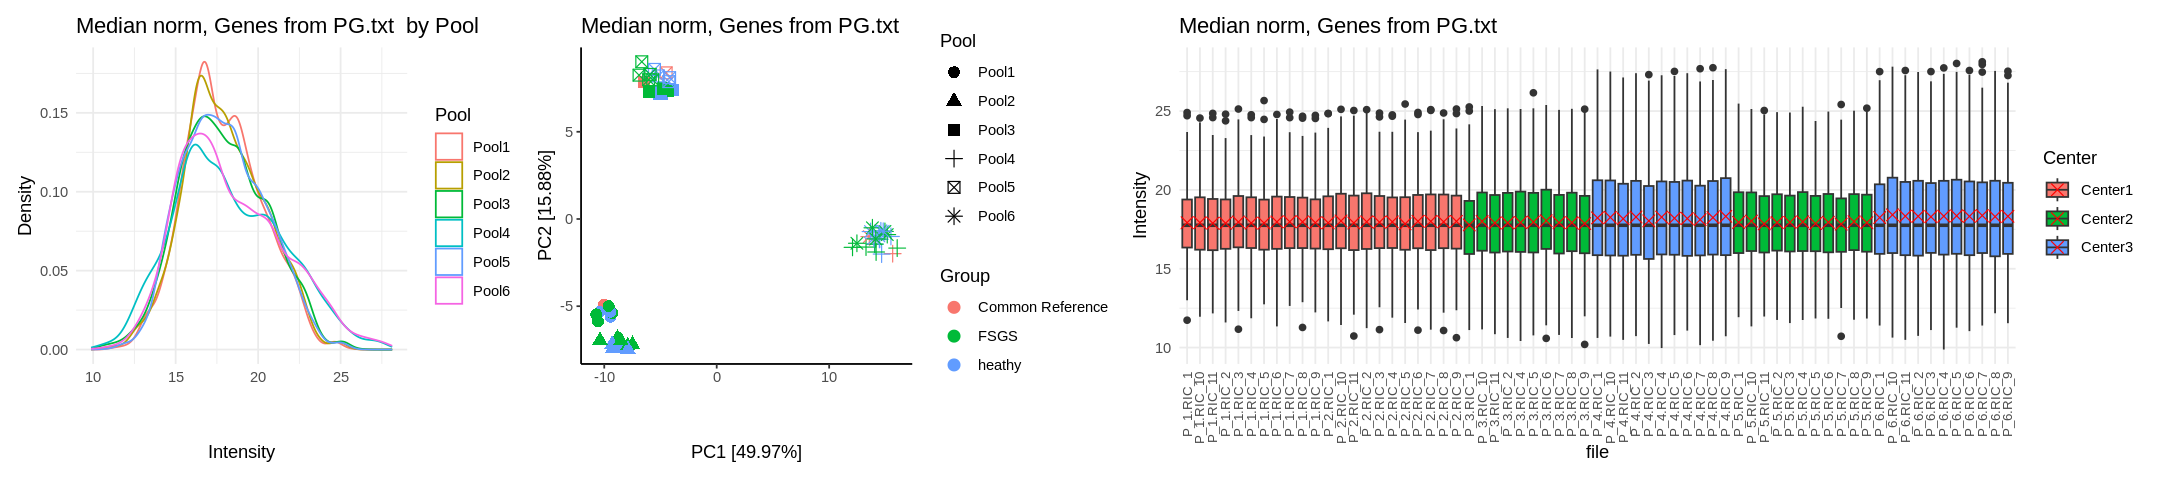

In [16]:

layout <- (plot_density + plot_pca) | (plot_boxplot)
options(repr.plot.width=18, repr.plot.height=4)
print(layout)

## irs on median

In [17]:
ref_samples <- metadata[metadata$Group == 'Common Reference',]$Quantitative.column.name
batch <- metadata$Pool

irs_on_medenianNorm_intensities <- irsNorm(medianNorm_intensities, metadata, batch, ref_samples)


No id variables; using all as measure variables



Warning message:
“Removed 419 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_summary()`).”


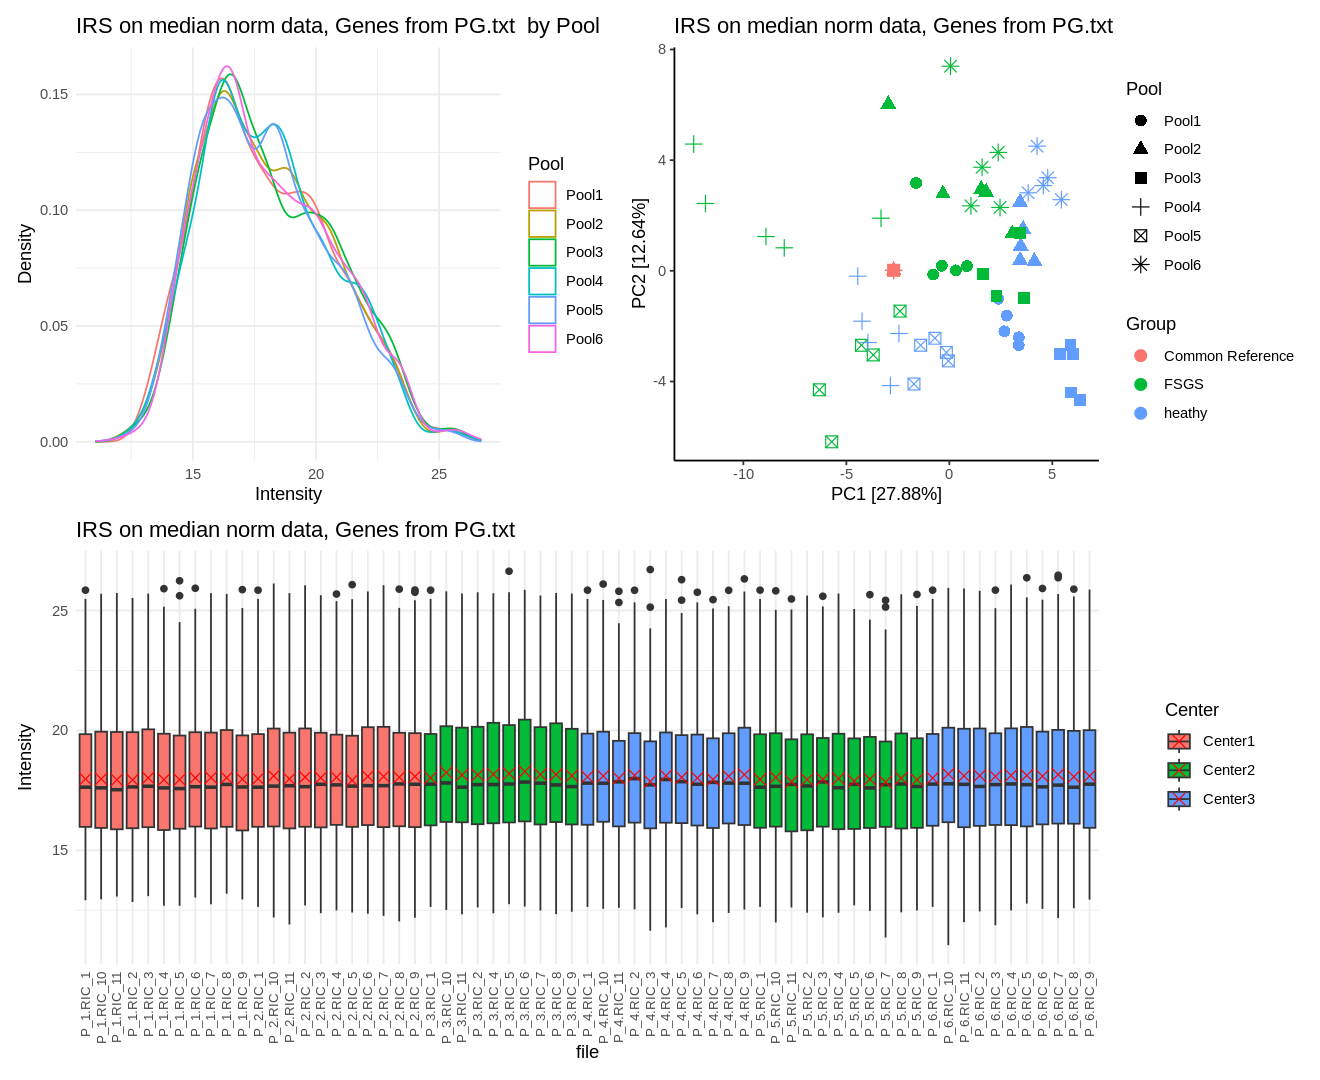

In [18]:
plot_density <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities+1), metadata, "Quantitative.column.name", "Pool", paste0("IRS on median norm data, ", title))
plot_pca <- pca_plot(log2(irs_on_medenianNorm_intensities+1), metadata, paste0("IRS on median norm data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(irs_on_medenianNorm_intensities+1), metadata, "Quantitative.column.name", "Center", paste0("IRS on median norm data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

In [19]:
irs_on_medenianNorm_intensities_inside_list <- NULL

for (center in centers) {
  ref_samples <- metadata[metadata$Group == 'Common Reference' & metadata$Center == center,]$Quantitative.column.name
  batch <- metadata[metadata$Center == center,]$Pool
  medianNorm_intensities_tmp <- select(medianNorm_intensities, metadata[metadata$Center == center,]$Quantitative.column.name)
  irs_on_medenianNorm_intensities_inside_list[[center]] <- irsNorm(medianNorm_intensities_tmp, metadata[metadata$Center == center,], batch, ref_samples)
}
irs_on_medenianNorm_intensities_inside <- do.call(cbind, irs_on_medenianNorm_intensities_inside_list)
colnames(irs_on_medenianNorm_intensities_inside) <- colnames(medianNorm_intensities)
dim(irs_on_medenianNorm_intensities_inside)

[1] 352  65

No id variables; using all as measure variables



Warning message:
“Removed 419 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_summary()`).”


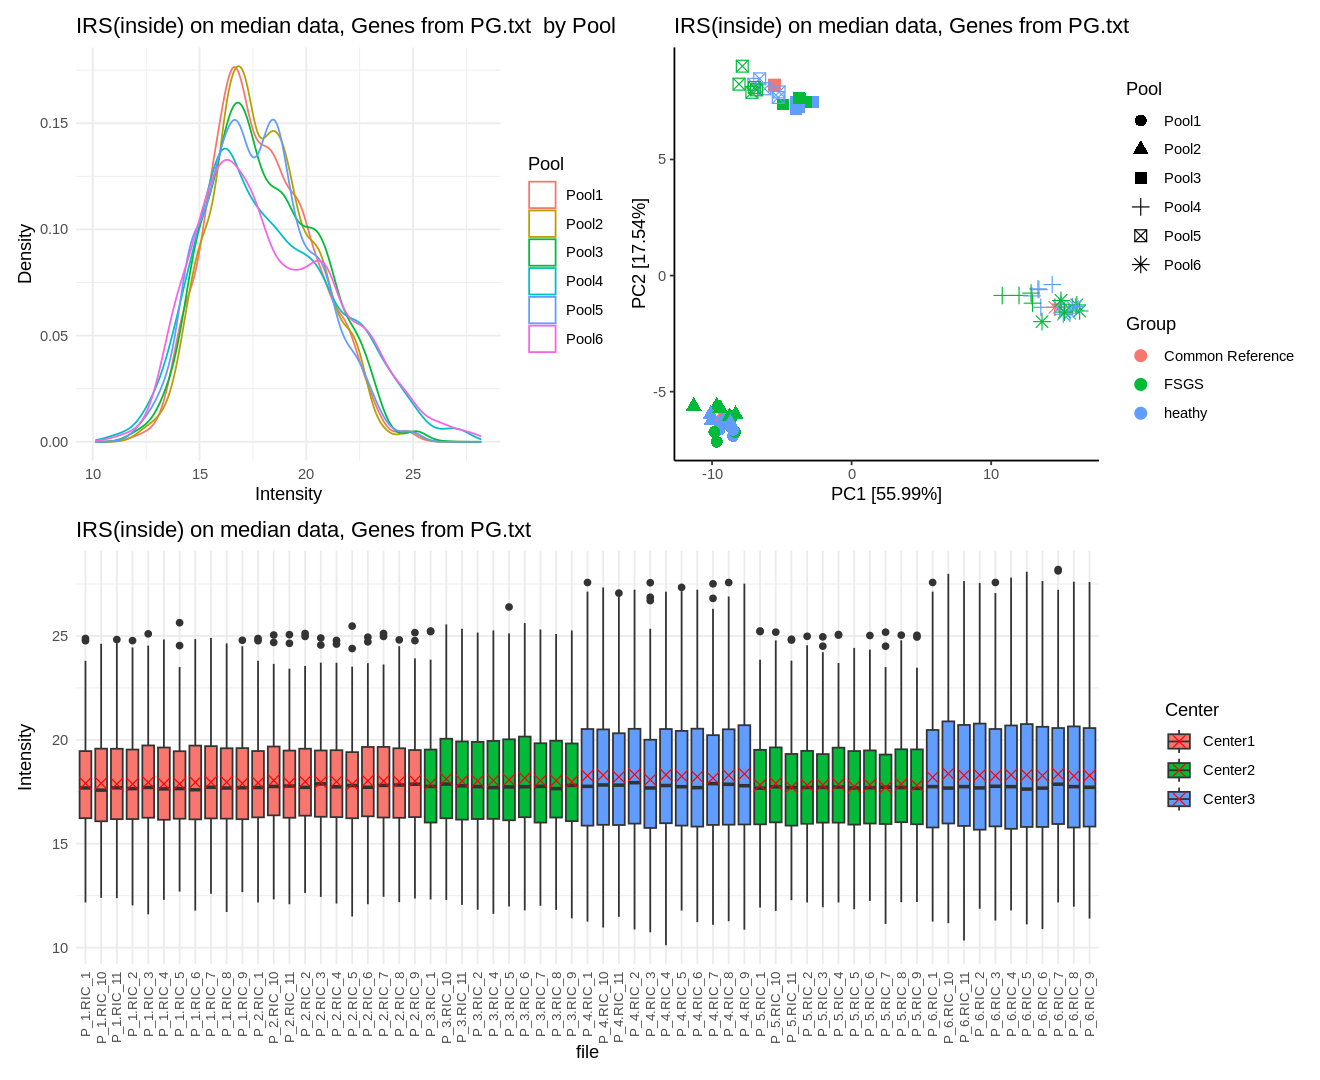

In [20]:
plot_density <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities_inside+1), metadata, "Quantitative.column.name", "Pool", paste0("IRS(inside) on median data, ", title))
plot_pca <- pca_plot(log2(irs_on_medenianNorm_intensities_inside+1), metadata, paste0("IRS(inside) on median data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(irs_on_medenianNorm_intensities_inside+1), metadata, "Quantitative.column.name", "Center", paste0("IRS(inside) on median data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Removed 88 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 92 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 239 rows containing non-finite values (`stat_density()`).”


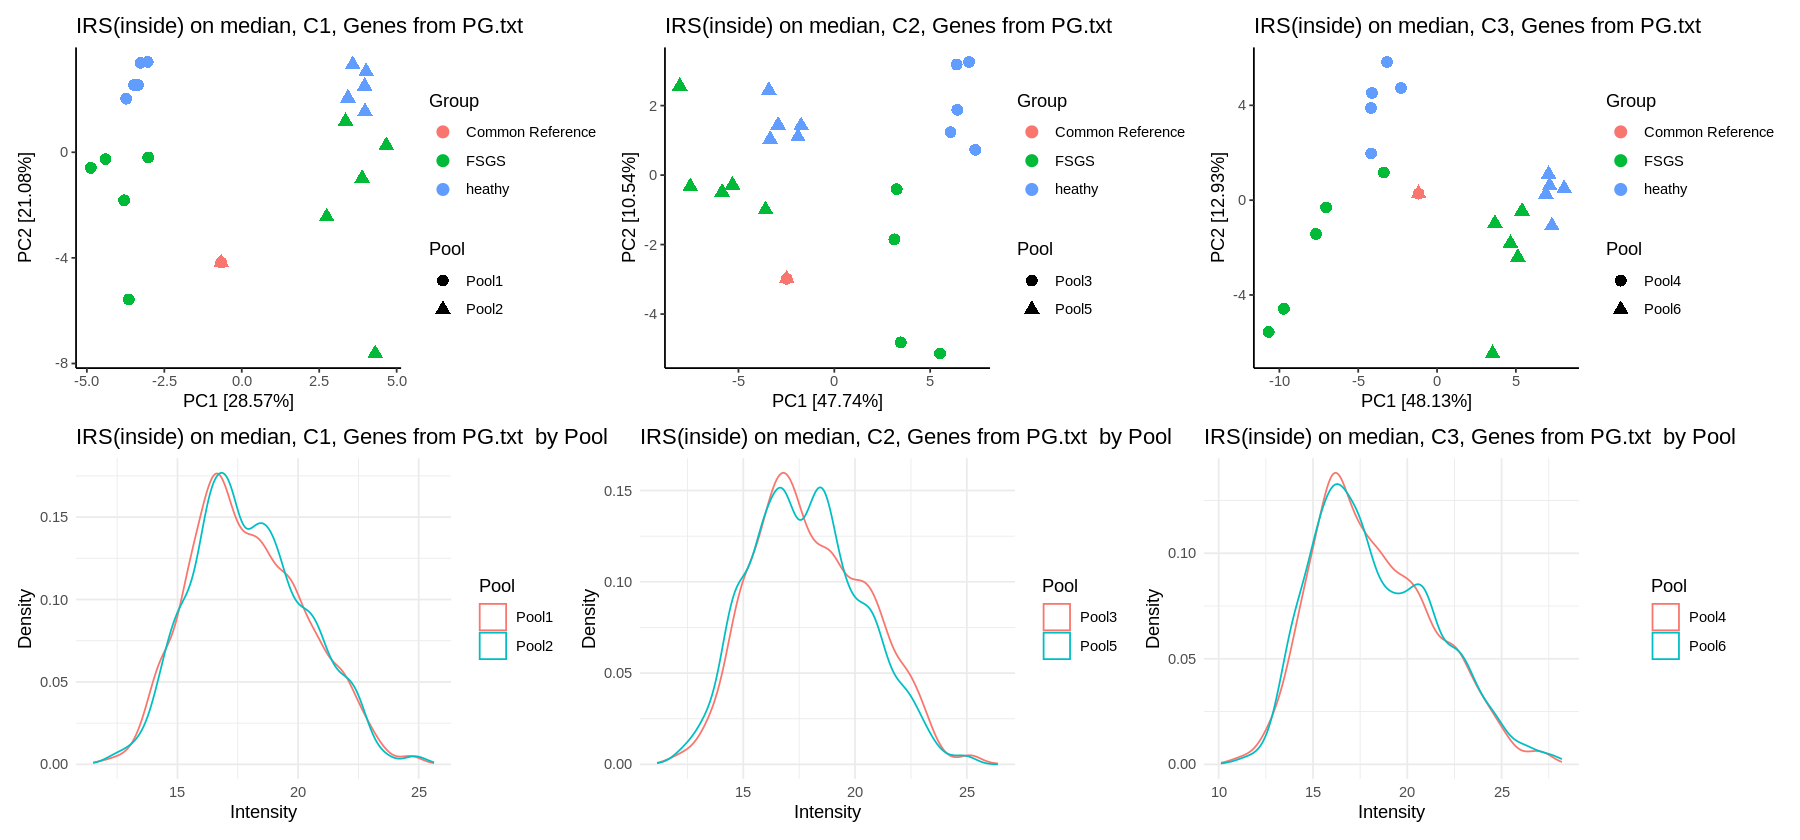

In [21]:
pca_center1_irs_on_median <- pca_plot(log2(irs_on_medenianNorm_intensities_inside_list$Center1+1), metadata[metadata$Center == "Center1",], paste0("IRS(inside) on median, C1, ", title), shape_col = "Pool")
pca_center2_irs_on_median <- pca_plot(log2(irs_on_medenianNorm_intensities_inside_list$Center2+1), metadata[metadata$Center == "Center2",], paste0("IRS(inside) on median, C2, ", title), shape_col = "Pool")
pca_center3_irs_on_median <- pca_plot(log2(irs_on_medenianNorm_intensities_inside_list$Center3+1), metadata[metadata$Center == "Center3",], paste0("IRS(inside) on median, C3, ", title), shape_col = "Pool")

density_plot_center1_irs_on_median <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities_inside_list$Center1+1), metadata[metadata$Center == "Center1",], "Quantitative.column.name", "Pool", paste0("IRS(inside) on median, C1, ", title))
density_plot_center2_irs_on_median <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities_inside_list$Center2+1), metadata[metadata$Center == "Center2",], "Quantitative.column.name", "Pool", paste0("IRS(inside) on median, C2, ", title))
density_plot_center3_irs_on_median <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities_inside_list$Center3+1), metadata[metadata$Center == "Center3",], "Quantitative.column.name", "Pool", paste0("IRS(inside) on median, C3, ", title))


layout <- (pca_center1_irs_on_median | pca_center2_irs_on_median | pca_center3_irs_on_median) /
          (density_plot_center1_irs_on_median | density_plot_center2_irs_on_median | density_plot_center3_irs_on_median)
options(repr.plot.width=15, repr.plot.height=7)
print(layout)


## limma

In [22]:
# bacth effects correction
design <- model.matrix(~0 + metadata$Group)
head(design)

batch <- metadata$Pool

,metadata$GroupCommon Reference,metadata$GroupFSGS,metadata$Groupheathy
1,1,0,0
2,0,0,1
3,0,1,0
4,0,0,1
5,0,1,0
6,0,0,1


Warning message:
“Partial NA coefficients for 33 probe(s)”
No id variables; using all as measure variables



Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_summary()`).”


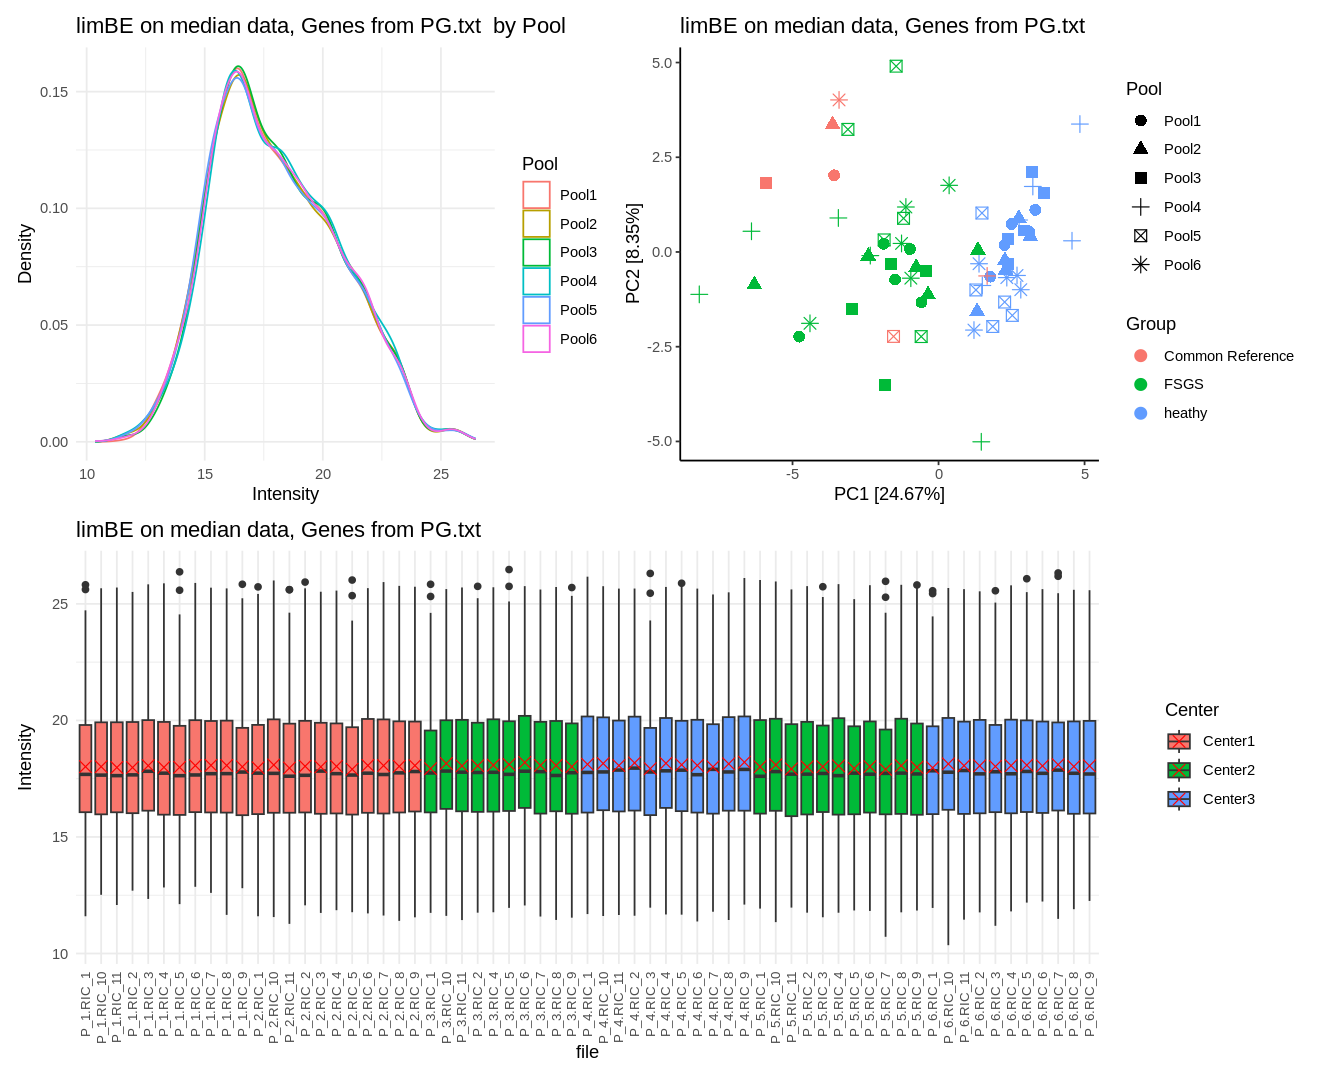

In [23]:
limBE_on_median <- limma::removeBatchEffect(log2(medianNorm_intensities + 1), batch = batch, design = design) %>%
    as.data.frame()
rownames(limBE_on_median) <- rownames(medianNorm_intensities)

plot_density <- plotIntensityDensityByPool(limBE_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limBE on median data, ", title))
plot_pca <- pca_plot(limBE_on_median, metadata, paste0("limBE on median data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(limBE_on_median, metadata, "Quantitative.column.name", "Center", paste0("limBE on median data, ", title), "")

layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)


In [24]:
# on all IRS
limBE_on_iRSall_on_median <- limma::removeBatchEffect(log2(irs_on_medenianNorm_intensities + 1), batch, design = design) %>% as.data.frame()
rownames(limBE_on_iRSall_on_median) <- rownames(irs_on_medenianNorm_intensities)
# on inside IRS
limBE_on_iRSinside_on_median <- limma::removeBatchEffect(log2(irs_on_medenianNorm_intensities_inside + 1), batch, design = design) %>% as.data.frame()
rownames(limBE_on_iRSinside_on_median) <- rownames(irs_on_medenianNorm_intensities_inside)

Warning message:
“Partial NA coefficients for 34 probe(s)”
Warning message:
“Partial NA coefficients for 34 probe(s)”


No id variables; using all as measure variables



Warning message:
“Removed 419 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_summary()`).”


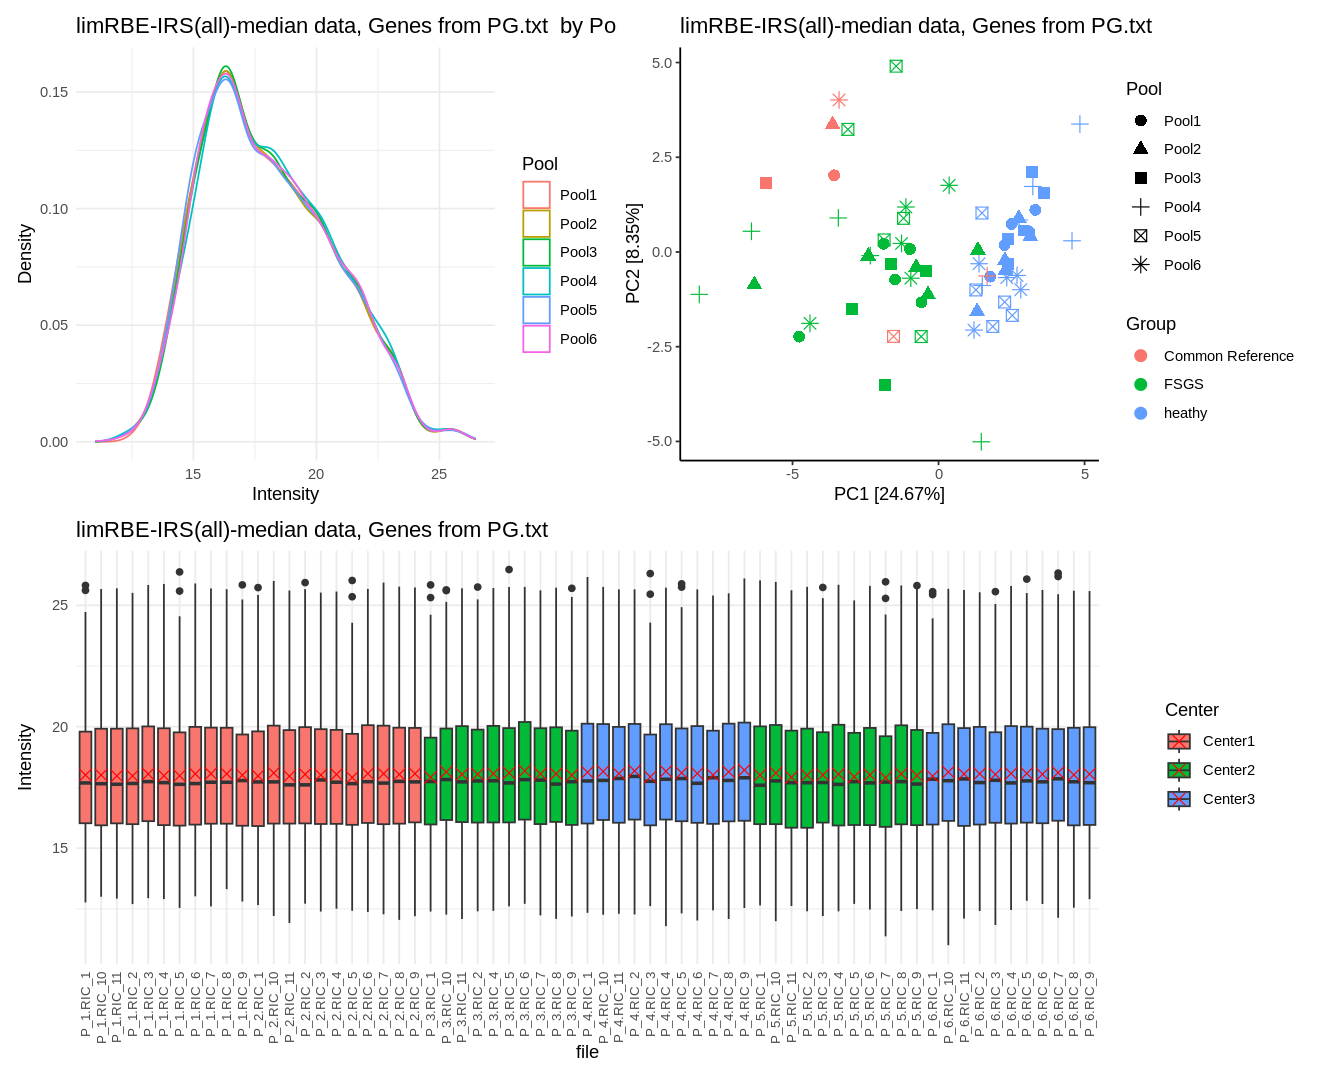

In [25]:
plot_density <- plotIntensityDensityByPool(limBE_on_iRSall_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limRBE-IRS(all)-median data, ", title))
plot_pca <- pca_plot(limBE_on_iRSall_on_median, metadata, paste0("limRBE-IRS(all)-median data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(limBE_on_iRSall_on_median, metadata, "Quantitative.column.name", "Center", paste0("limRBE-IRS(all)-median data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

No id variables; using all as measure variables

Warning message:
“Removed 419 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_summary()`).”


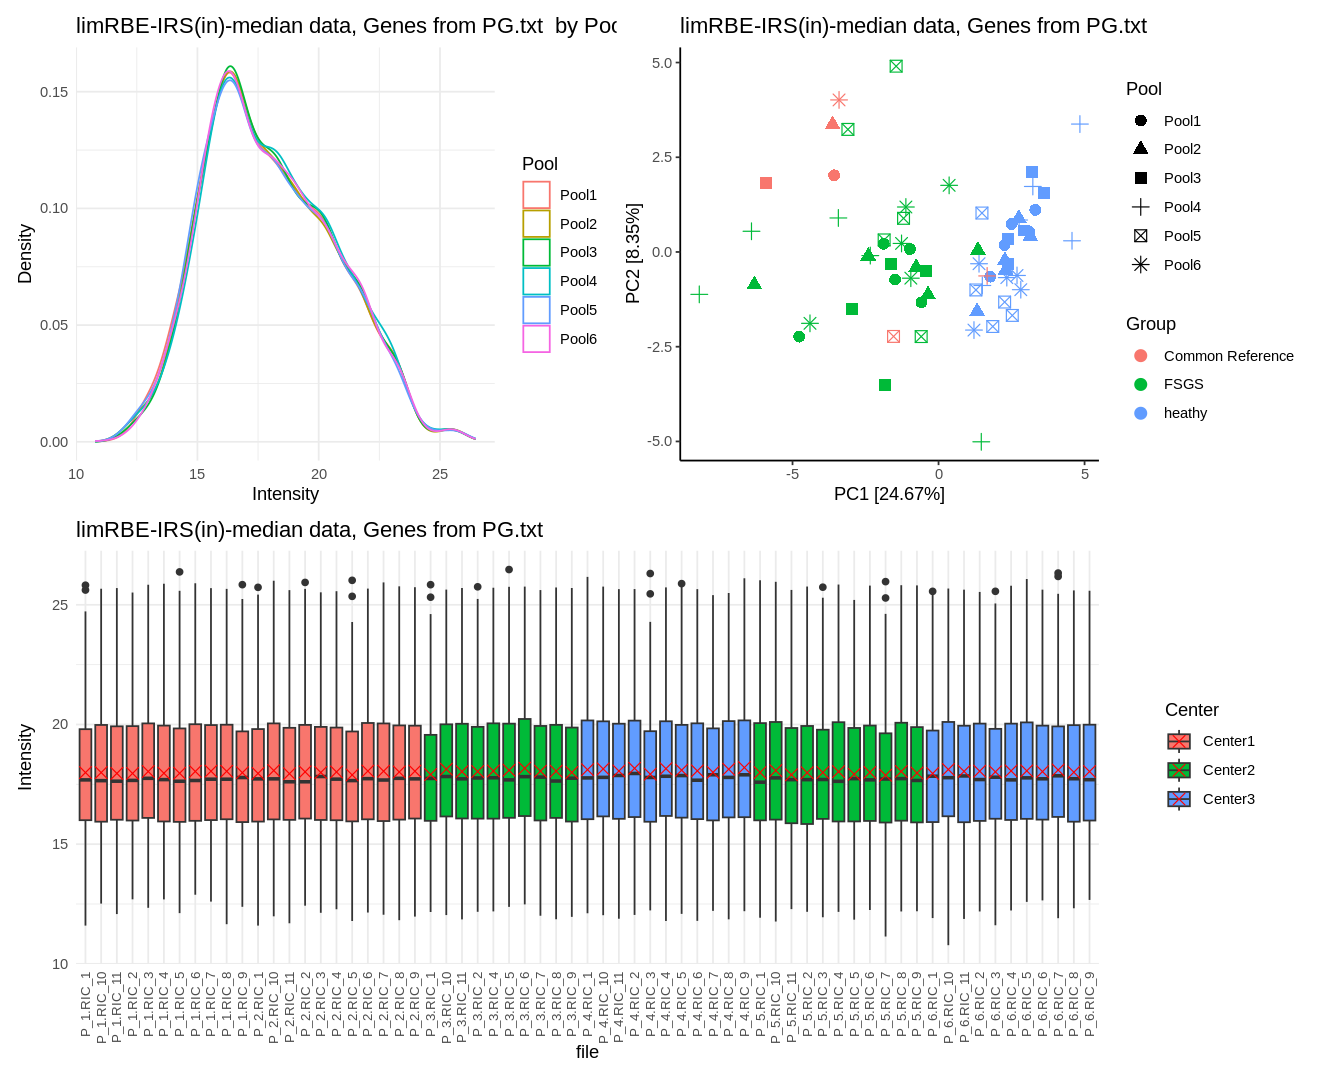

In [26]:
plot_density <- plotIntensityDensityByPool(limBE_on_iRSinside_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limRBE-IRS(in)-median data, ", title))
plot_pca <- pca_plot(limBE_on_iRSinside_on_median, metadata, paste0("limRBE-IRS(in)-median data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(limBE_on_iRSinside_on_median, metadata, "Quantitative.column.name", "Center", paste0("limRBE-IRS(in)-median data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

results

In [27]:
limrbe_on_raw <- limma::removeBatchEffect(log2(intensities + 1), batch, design = design) %>% as.data.frame()
rownames(limrbe_on_raw) <- rownames(intensities)

Warning message:
“Partial NA coefficients for 33 probe(s)”


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_density()`).”


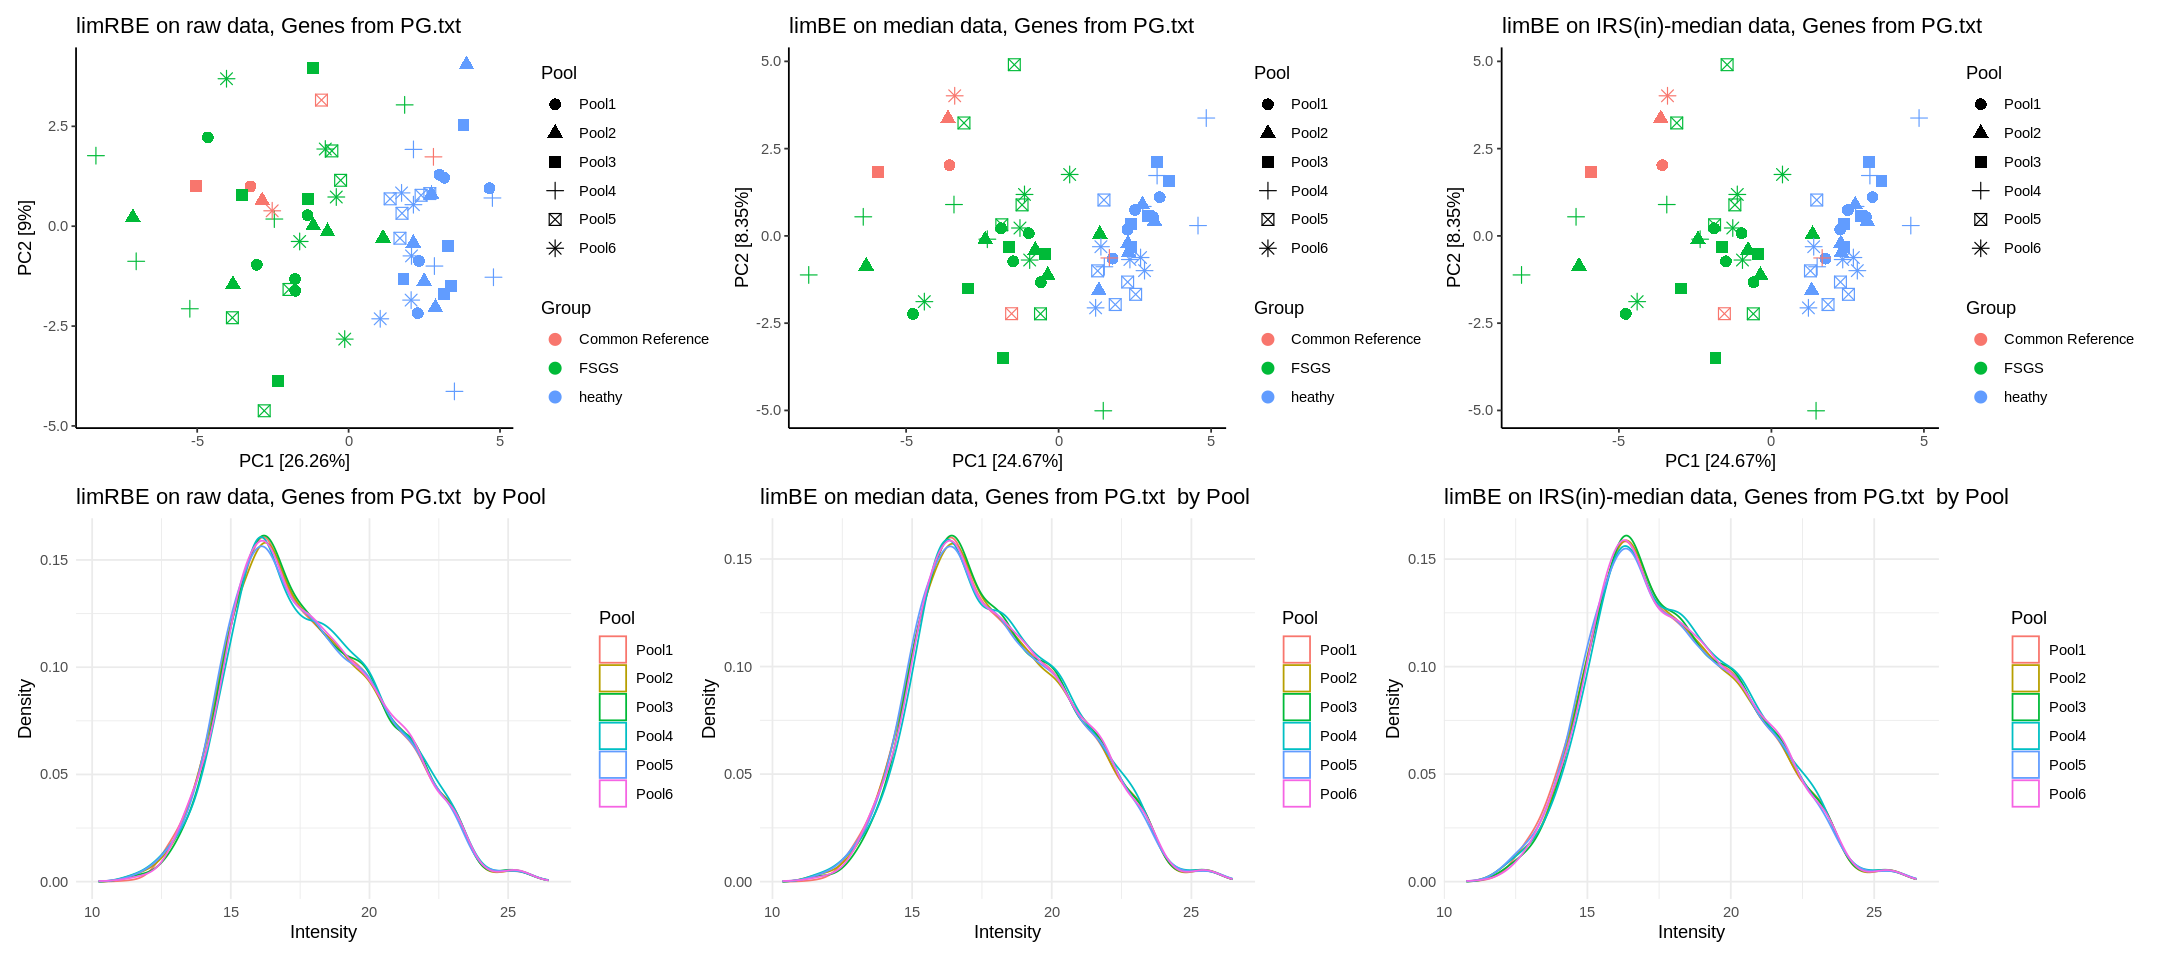

In [28]:
#limrbe on raw pca
pca_1 <- pca_plot(limrbe_on_raw, metadata, paste0("limRBE on raw data, ", title), shape_col = "Pool", col_col = "Group")
# pca for limbec_on_median
pca_2 <- pca_plot(limBE_on_median, metadata, paste0("limBE on median data, ", title), shape_col = "Pool", col_col = "Group")
# pca for limbec_on_iRSinside_on_median
pca_3 <- pca_plot(limBE_on_iRSinside_on_median, metadata, paste0("limBE on IRS(in)-median data, ", title), shape_col = "Pool", col_col = "Group")

density_1 <- plotIntensityDensityByPool(limrbe_on_raw, metadata, "Quantitative.column.name", "Pool", paste0("limRBE on raw data, ", title))
density_2 <- plotIntensityDensityByPool(limBE_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limBE on median data, ", title))
density_3 <- plotIntensityDensityByPool(limBE_on_iRSinside_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limBE on IRS(in)-median data, ", title))


layout <- (pca_1 | pca_2 | pca_3) /
          (density_1 | density_2 | density_3)
options(repr.plot.width=18, repr.plot.height=8)
print(layout)

Warning message:
“Removed 415 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 419 rows containing non-finite values (`stat_summary()`).”


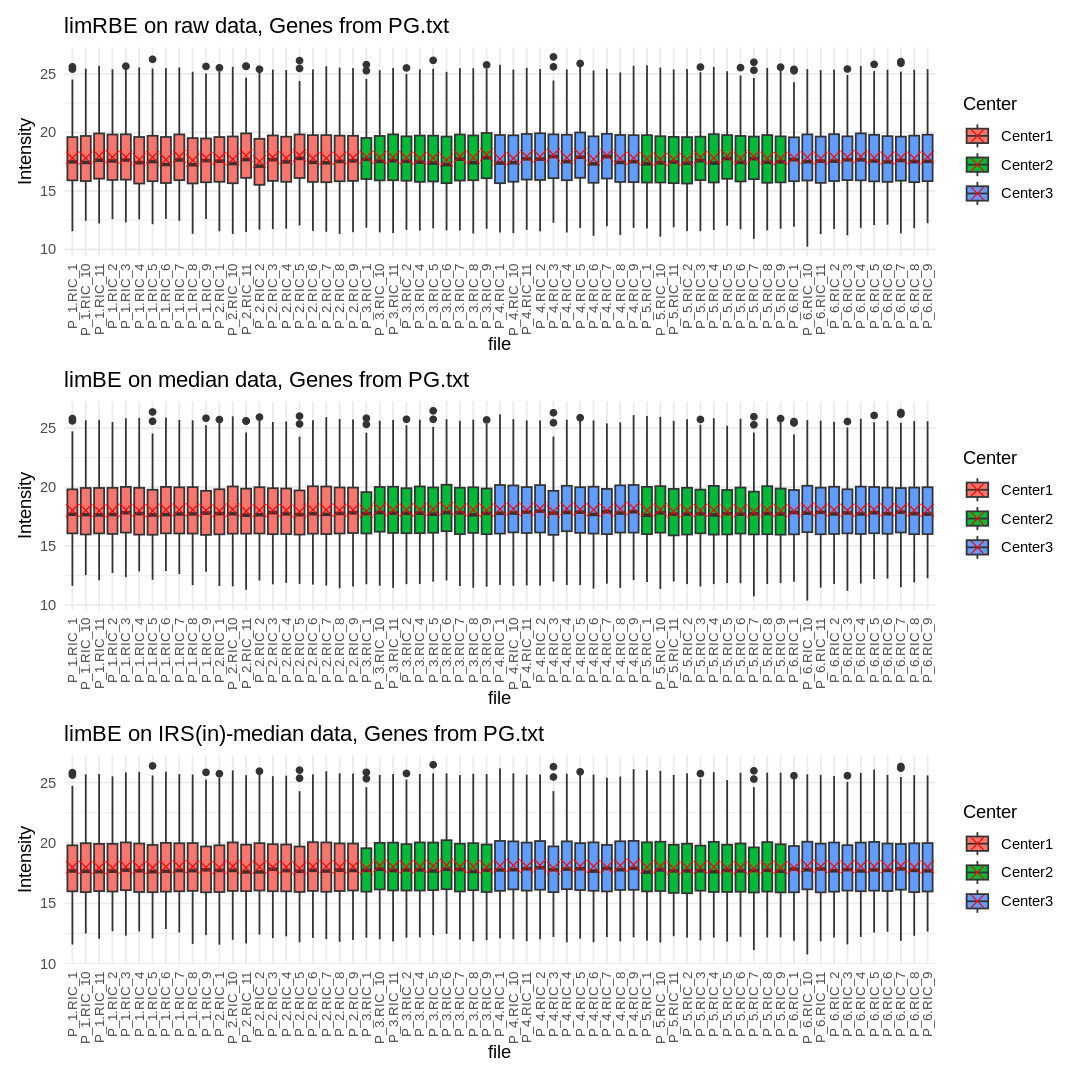

In [29]:
boxplot_1 <- boxplot_pg(limrbe_on_raw, metadata, "Quantitative.column.name", "Center", paste0("limRBE on raw data, ", title), "")
boxplot_2 <- boxplot_pg(limBE_on_median, metadata, "Quantitative.column.name", "Center", paste0("limBE on median data, ", title), "")
boxplot_3 <- boxplot_pg(limBE_on_iRSinside_on_median, metadata, "Quantitative.column.name", "Center", paste0("limBE on IRS(in)-median data, ", title), "")

layout <- (boxplot_1) / 
          (boxplot_2) / 
          (boxplot_3)

options(repr.plot.width=9, repr.plot.height=9)

print(layout)

# DE analysis

### DE on raw data using pools

In [30]:
log_intensities <- log2(intensities + 1)
# remove reference samples
ref_samples <- metadata[metadata$Group == 'Common Reference',]$"Quantitative.column.name"
log_intensities <- log_intensities[,!colnames(log_intensities) %in% ref_samples]
metadata_de <- metadata[!metadata$Group == 'Common Reference',]

metadata_de <- metadata_de %>%
    mutate(Group = as.factor(Group), Pool = as.factor(Pool))

In [31]:
design <- model.matrix(~0 + metadata_de$Group + metadata_de$Pool)
colnames(design) <- c(levels(metadata_de$Group), levels(metadata_de$Pool)[-1])

contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

In [32]:

fit <- lmFit(log_intensities, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_on_raw <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
head(results_on_raw, 2)

Warning message:
“Partial NA coefficients for 33 probe(s)”


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,-0.01981554,-0.10256948,0.06293839,21.20969,-0.4794934,0.63342240,0.71234723,-6.736112
A2M,0.37696126,0.08554245,0.66838007,22.43044,2.5902661,0.01215451,0.02473056,-3.661802


Warning message:
“ggrepel: 68 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


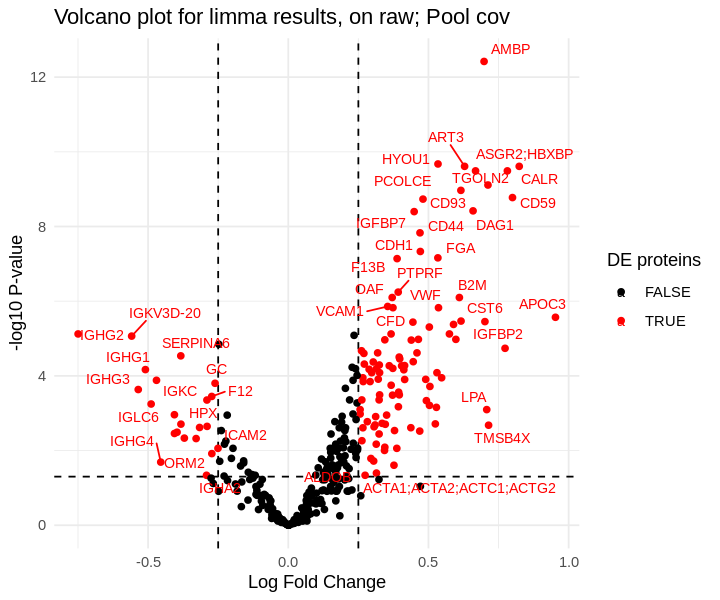

In [33]:
options(repr.plot.width=6, repr.plot.height=5)
volcano_plot(results_on_raw, "on raw; Pool cov")

### DE on median norm using pools

In [34]:
log_median <- log2(medianNorm(intensities) + 1) %>% as.data.frame()
# add rownames
rownames(log_median) <- rownames(intensities)
# remove reference samples
log_median <- log_median[,!colnames(log_median) %in% ref_samples]

In [35]:
fit <- lmFit(log_median, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_on_median <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
head(results_on_median, 2)

Warning message:
“Partial NA coefficients for 33 probe(s)”


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,-0.1968538,-0.28580670,-0.1079008,21.43156,-4.431944,4.327489e-05,0.0002176109,1.669148
A2M,0.1999230,-0.08083454,0.4806805,22.65231,1.426075,1.593274e-01,0.2343323636,-5.784911


Warning message:
“ggrepel: 28 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


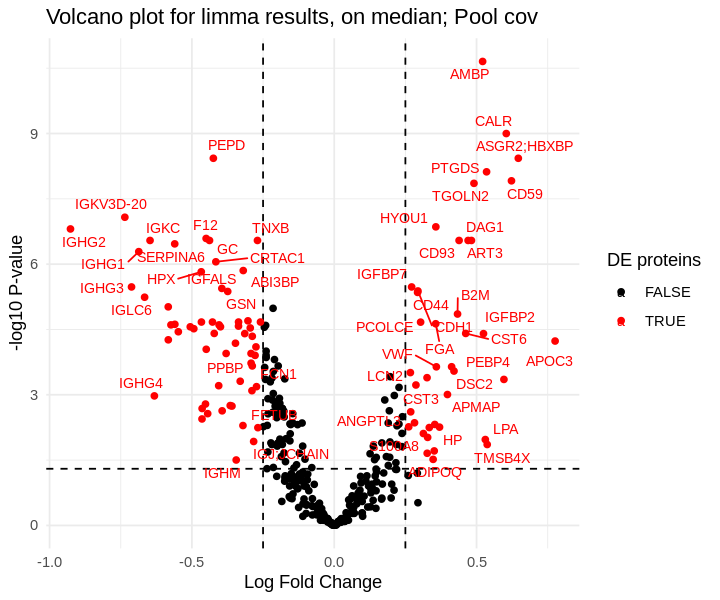

In [36]:
options(repr.plot.width=6, repr.plot.height=5)
volcano_plot(results_on_median, "on median; Pool cov")

In [37]:
log_irs_on_median <- log2(irs_on_medenianNorm_intensities_inside + 1) %>% as.data.frame()
rownames(log_irs_on_median) <- rownames(intensities)
log_irs_on_median <- log_irs_on_median[,!colnames(log_irs_on_median) %in% ref_samples]

In [38]:
fit <- lmFit(log_irs_on_median, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_irs_on_median <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
head(results_irs_on_median, 2)

Warning message:
“Partial NA coefficients for 34 probe(s)”


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,-0.1968537,-0.28580720,-0.1079003,21.42822,-4.431910,4.327498e-05,0.0002176113,1.669114
A2M,0.1999230,-0.08082269,0.4806687,22.65377,1.426132,1.593104e-01,0.2343096260,-5.784851


Warning message:
“ggrepel: 28 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


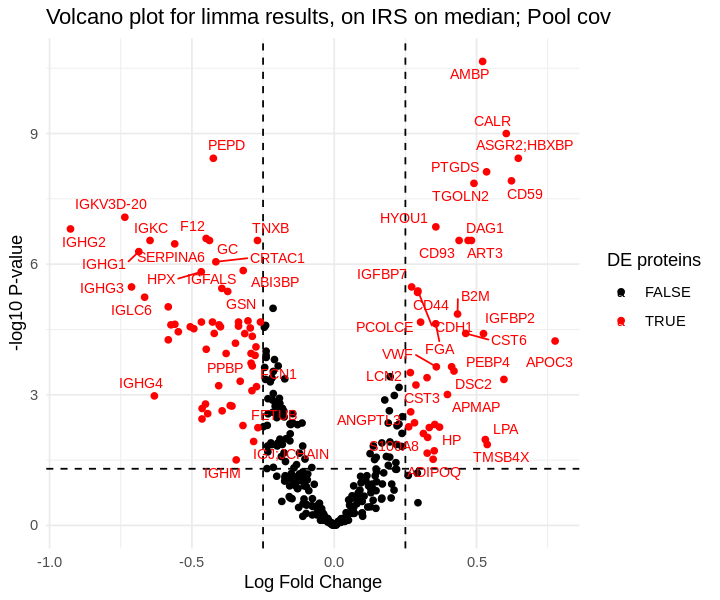

In [39]:
options(repr.plot.width=6, repr.plot.height=5)
volcano_plot(results_irs_on_median, "on IRS on median; Pool cov")

Warning message:
“ggrepel: 101 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 82 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 82 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


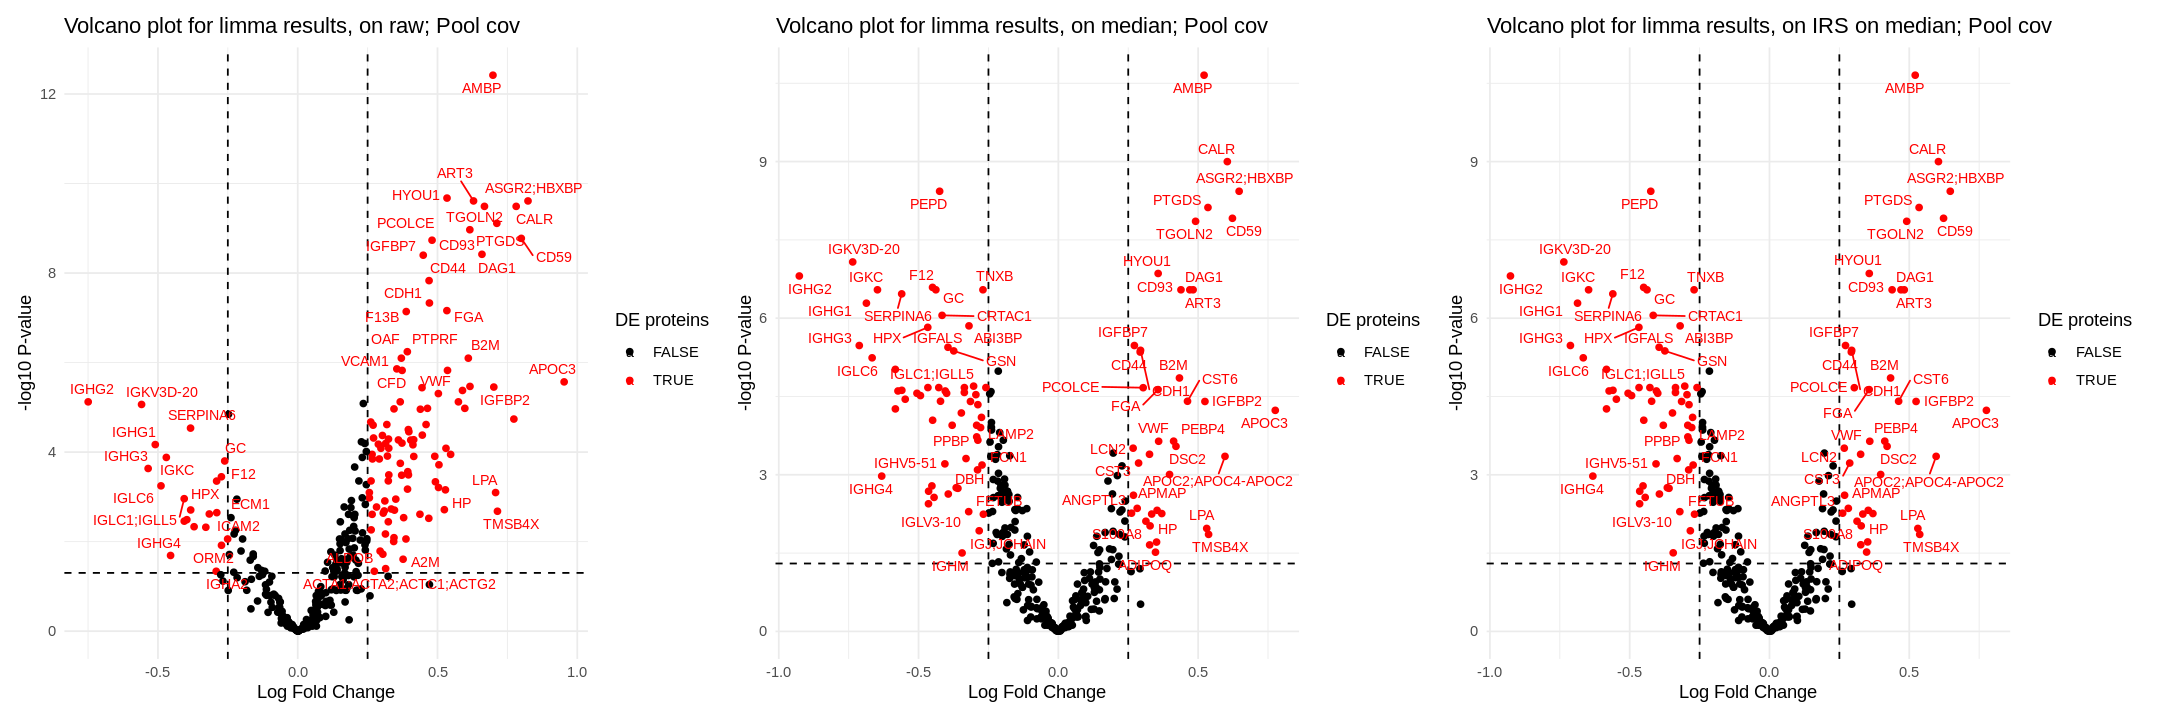

In [40]:
plot_1 <- volcano_plot(results_on_raw, "on raw; Pool cov")
plot_2 <- volcano_plot(results_on_median, "on median; Pool cov")
plot_3 <- volcano_plot(results_irs_on_median, "on IRS on median; Pool cov")

layout <- (plot_1 | plot_2 | plot_3)
options(repr.plot.width=18, repr.plot.height=6)
print(layout)

# Save results
use the median-irs(inside)-DE

In [41]:
library(DEqMS)

Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.2.3”

Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




In [42]:
counts <- list()

for(center in c("Center1", "Center2", "Center3")) {
  count <- read.csv(file.path('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/01_PG_Genes', center, "genes_counts_v2.tsv"), sep = "\t")
  counts[[center]] <- count
}

# merger three keeping for each gene the minimum value
# so, there is two columns, Gene.names - merge by this, and Unique.peptides -- keep the minimum
counts <- Reduce(function(x, y) {
  merge(x, y, by = "Gene.names") %>%
    mutate(Unique.peptides = pmin(Unique.peptides.x, Unique.peptides.y)) %>%
    select(-Unique.peptides.x, -Unique.peptides.y)
}, counts) %>%
  column_to_rownames("Gene.names")

In [43]:
one_peptide_proteins <- counts[counts$Unique.peptides == 1,]
length(one_peptide_proteins)


cat('Before filtering:', dim(intensities), '\n')
intensities <- intensities[!rownames(intensities) %in% rownames(one_peptide_proteins),]
cat('After filtering:', dim(intensities))

[1] 6

Before filtering: 352 65 
After filtering: 352 65

In [44]:
medianNorm_intensities <- medianNorm(intensities)

In [45]:
irs_on_medenianNorm_intensities_inside_list <- NULL

for (center in centers) {
  ref_samples <- metadata[metadata$Group == 'Common Reference' & metadata$Center == center,]$Quantitative.column.name
  batch <- metadata[metadata$Center == center,]$Pool
  medianNorm_intensities_tmp <- select(medianNorm_intensities, metadata[metadata$Center == center,]$Quantitative.column.name)
  irs_on_medenianNorm_intensities_inside_list[[center]] <- irsNorm(medianNorm_intensities_tmp, metadata[metadata$Center == center,], batch, ref_samples)
}
irs_on_medenianNorm_intensities_inside <- do.call(cbind, irs_on_medenianNorm_intensities_inside_list)
colnames(irs_on_medenianNorm_intensities_inside) <- colnames(medianNorm_intensities)
dim(irs_on_medenianNorm_intensities_inside)

[1] 352  65

In [46]:
ref_samples <- metadata[metadata$Group == 'Common Reference',]$"Quantitative.column.name"
metadata_de <- metadata[!metadata$Group == 'Common Reference',]
metadata_de <- metadata_de %>%
    mutate(Group = as.factor(Group), Pool = as.factor(Pool))

In [47]:
log_irs_on_median <- log2(irs_on_medenianNorm_intensities_inside + 1) %>% as.data.frame()
rownames(log_irs_on_median) <- rownames(intensities)
log_irs_on_median <- log_irs_on_median[,!colnames(log_irs_on_median) %in% ref_samples]
cat('Number of rows in log_irs_on_median:', nrow(log_irs_on_median), '\n')
cat('Number of columns in log_irs_on_median:', ncol(log_irs_on_median), '\n')

Number of rows in log_irs_on_median: 352 
Number of columns in log_irs_on_median: 59 


In [48]:
design <- model.matrix(~0 + metadata_de$Group + metadata_de$Pool)
colnames(design) <- c(levels(metadata_de$Group), levels(metadata_de$Pool)[-1])

contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

In [49]:
fit <- lmFit(log_irs_on_median, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

fit3$count <- counts[rownames(fit3$coefficients), "Unique.peptides"] + 1
if(is.na(min(fit3$count)) | min(fit3$count) == 0){
  print("No DEqMS results")
}

fit4 <- spectraCounteBayes(fit3)
results_irs_on_median <- outputResult(fit4, coef_col = 1)
head(results_irs_on_median, 2)

Warning message:
“Partial NA coefficients for 34 probe(s)”


,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,count,sca.t,sca.P.Value,sca.adj.pval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AMBP,0.5213037,21.37673,9.874241,6.281541e-14,2.211103e-11,21.46979,AMBP,19,9.984009,3.987477e-14,1.403592e-11
CALR,0.6044204,16.92725,8.664890,5.682498e-12,1.000120e-09,17.07483,CALR,6,8.634211,6.142411e-12,1.081064e-09


In [50]:
# save results_irs_on_median to file in tsv format
write.table(results_irs_on_median, file = "./Central_res_irs_on_median.tsv", sep = "\t", quote = FALSE, row.names = TRUE)

# Run Meta for selected 

In [51]:
outputResult <-function(fit,coef_col=1){
    results.table = limma::topTable(fit, coef=coef_col, n= Inf, confint=TRUE)
    
    results.table$gene = rownames(results.table)
    results.table$count = fit$count[results.table$gene]
    
    results.table$sca.t = fit$sca.t[results.table$gene,coef_col]
    results.table$P.Value = fit$sca.p[results.table$gene,coef_col]
    results.table$sca.P.Value = fit$sca.p[results.table$gene,coef_col]
    results.table$adj.P.Val = p.adjust(results.table$sca.P.Value, method = "BH")
    results.table$sca.adj.pval = p.adjust(results.table$sca.P.Value, method = "BH")
    results.table = results.table[order(results.table$sca.P.Value), ]
}

In [52]:
metadata_de <- metadata #[!metadata$Group == 'Common Reference',]

plots <- list()

for(center in c("Center1", "Center2", 'Center3')){
    ref_samples <- metadata_de %>%
        filter(Group == 'Common Reference') %>%
        filter(Center == center) %>%
        pull(Quantitative.column.name)
    # metadata_de[metadata_de$Group == 'Common Reference',][metadata_de$Center == center,]$Quantitative.column.name
    center_meta <- metadata_de[metadata_de$Center == center,]

    # prepare counts
    counts <- read.csv(file.path('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/01_PG_Genes', center, "genes_counts_v2.tsv"), sep = "\t")
    counts <- counts %>% column_to_rownames("Gene.names")
    
    # prepare intensities
    center_intensities_non <- intensities[,center_meta$Quantitative.column.name]
    center_intensities <- medianNorm(center_intensities_non)
    center_intensities <- irsNorm(center_intensities, center_meta, center_meta$Pool, ref_samples) %>% as.data.frame()
    rownames(center_intensities) <- rownames(center_intensities_non)

    # exclude reference samples
    center_meta <- center_meta[!center_meta$Quantitative.column.name %in% ref_samples,]
    center_intensities <- center_intensities[,!colnames(center_intensities) %in% ref_samples]
    center_intensities <- log2(center_intensities + 1)
    cat('Shape of metadata for ', center, ' is ', dim(center_meta), '\n')
    cat('Shape of intensities for ', center, ' is ', dim(center_intensities), '\n')


    # prepare contrasts
    center_meta <- center_meta %>%
        mutate(Group = as.factor(Group), Pool = as.factor(Pool))
    design <- model.matrix(~0 + center_meta$Group + center_meta$Pool)
    colnames(design) <- c(levels(center_meta$Group), levels(center_meta$Pool)[-1])
    contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

    fit <- lmFit(center_intensities, design)
    fit2 <- contrasts.fit(fit, contrasts)
    fit3 <- eBayes(fit2)

    fit3$count <- counts[rownames(fit3$coefficients), "Unique.peptides"] + 1
    if(is.na(min(fit3$count)) | min(fit3$count) == 0){
        print("No DEqMS results")
        }

    fit4 <- spectraCounteBayes(fit3)
    result <- outputResult(fit4, coef_col = 1)
    # sort result based on rownames in intensities
    result <- result[rownames(center_intensities),]
    # save results_irs_on_median to file in tsv format
    result %>% rownames_to_column("PG") %>% write.table(., file = paste0("../MA_data_gene/", center, "_res.tsv"), sep = "\t", quote = FALSE, row.names = FALSE)
    
    # create volcano plot
    plot <- volcano_plot(result, paste0(center, ", Genes"), show_names = FALSE, show_legend = FALSE)
    plots[[center]] <- plot
}

Shape of metadata for  Center1  is  20 7 
Shape of intensities for  Center1  is  352 20 


Warning message:
“Partial NA coefficients for 8 probe(s)”


Shape of metadata for  Center2  is  19 7 
Shape of intensities for  Center2  is  352 19 


Warning message:
“Partial NA coefficients for 9 probe(s)”


Shape of metadata for  Center3  is  20 7 
Shape of intensities for  Center3  is  352 20 


Warning message:
“Partial NA coefficients for 21 probe(s)”


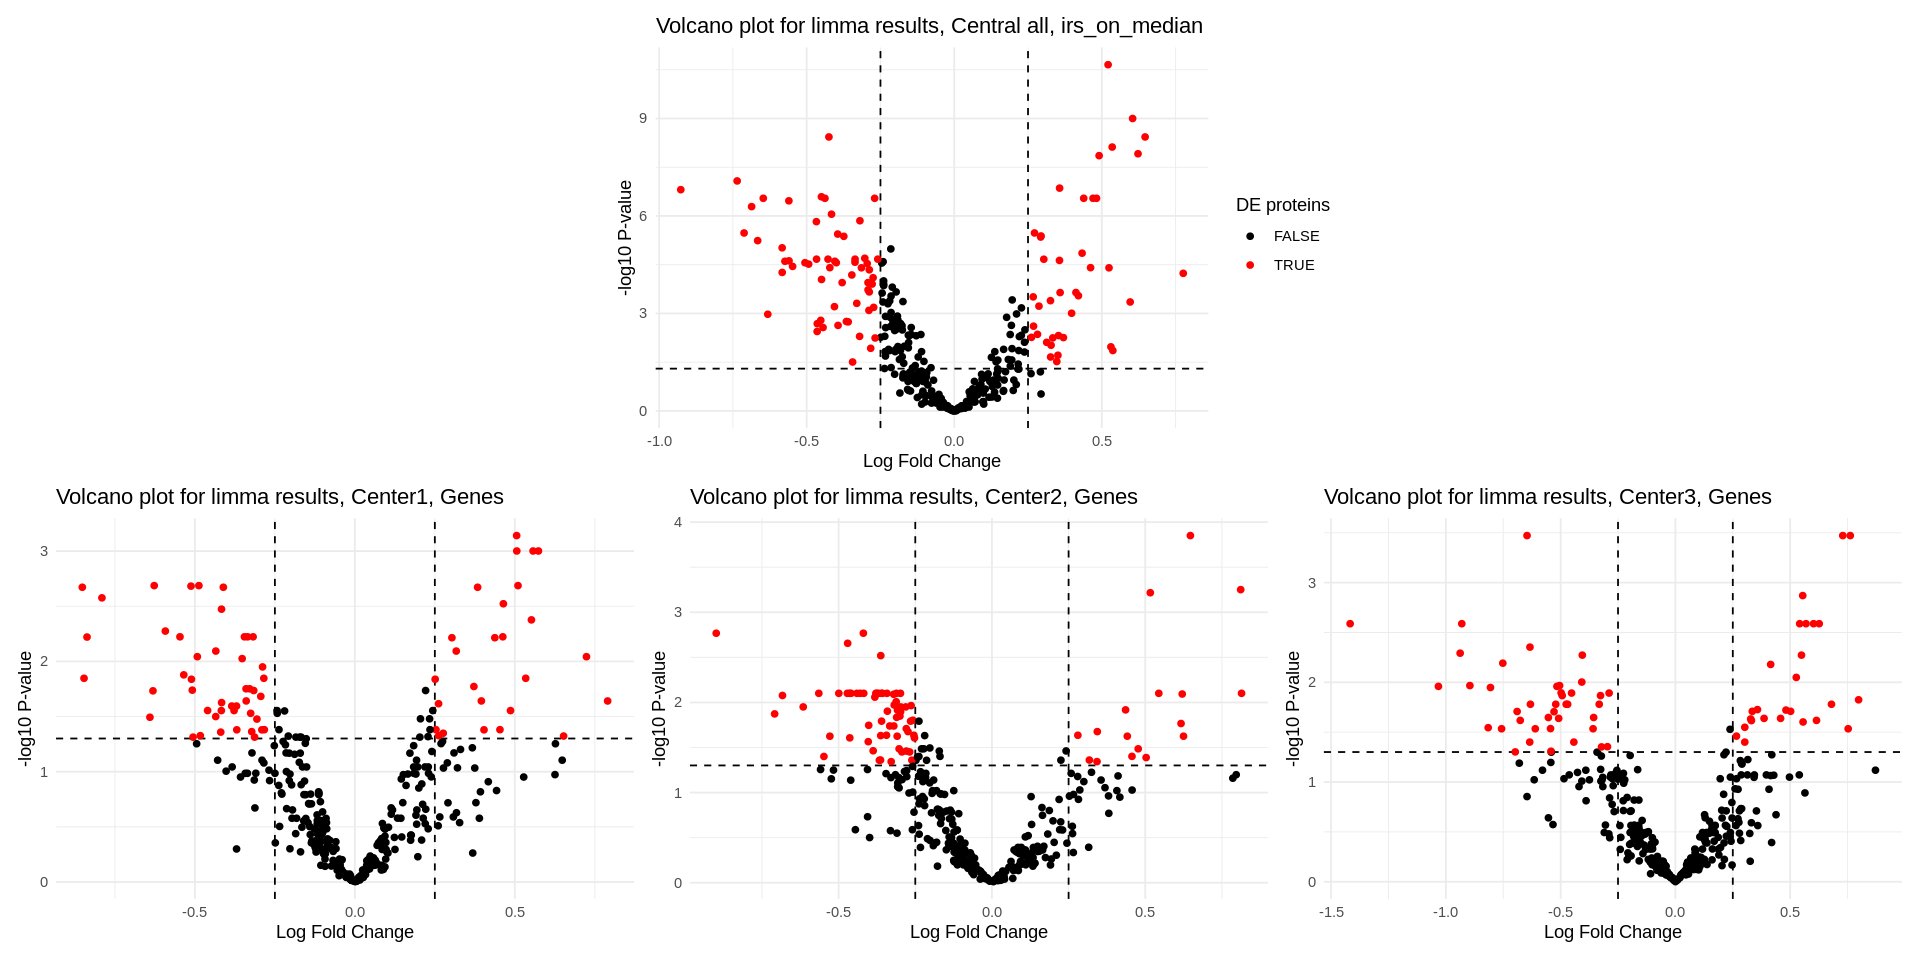

In [54]:
x <- ggplot() + theme_void()
layout <- (x | volcano_plot(results_irs_on_median, "Central all, irs_on_median", show_names = FALSE) | x) / 
          (plots[['Center1']] | plots[['Center2']] | plots[['Center3']])
options(repr.plot.width=16, repr.plot.height=8)
print(layout)

### run meta

In [184]:
Rscript /home/yuliya/repos/cosybio/FedProt/evaluation/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/ Center1 Center2 Center3
Rscript /home/yuliya/repos/cosybio/FedProt/evaluation/meta_code/run_MetaVolcanoR.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/ Center1 Center2 Center3
Rscript /home/yuliya/repos/cosybio/FedProt/evaluation/meta_code/run_RankProd.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/ Center1 Center2 Center3


ERROR: Error in parse(text = x, srcfile = src): <text>:1:166: unexpected symbol
1: Rscript /home/yuliya/repos/cosybio/FedProt/evaluation/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/ Center1 Center2
                                                                                                                                                                         ^


In [ ]:
cp /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/MA_*.tsv /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/gene/